我把一些東西都直接註解在程式碼裡面，阿如果不想看就把class關起來跑完直接跑下一個block

In [ ]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

class GBMSimulator:
    def __init__(self, ticker, start_date, end_date):

        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.S0 = None     
        self.mu = None
        self.r = None      
        self.sigma = None    
        self.n_paths = None 
        
    def fit_data(self):

        self.data = yf.download(self.ticker, start=self.start_date, end=self.end_date, auto_adjust = True)
                   
        price = self.data['Close']
        
        if isinstance(price, pd.DataFrame):
            price = price.iloc[:, 0]
        
        log_returns = np.log(price / price.shift(1)).dropna()
        self.mu = log_returns.mean()
        self.sigma = log_returns.std()
        self.S0 = float(price.iloc[-1])

        print(f"下載資料完成: {self.ticker}")

    def simulate(self, T_years, n_days, n_paths, measure="P",r=0.02, seed=10):

        np.random.seed(seed)
        self.mu *= n_days
        self.r = r
        self.sigma *= np.sqrt(n_days)
        dt = 1 / n_days
        
        # 建立時間軸
        # [0, dt, 2*dt, ..., n_days * T_years*dt]
        self.t = np.array(range(0, n_days * T_years + 1, 1)) * dt

        # 1. 計算漂移項
        if measure == "P" :
            drift = (self.mu - 0.5 * self.sigma ** 2)
        elif measure == "Q" :
            drift = (self.r - 0.5 * self.sigma ** 2)
        else :
            raise TypeError("我只有寫P跟Q測度，請二選一")
        
        # 2. 計算隨機項
        volatility = self.sigma * np.sqrt(dt)
        
        # 產生增量
        # 初始是0 從索引1開始，填入常態分佈隨機數
        increment = np.zeros(shape = (n_days * T_years + 1, n_paths)) 
        increment[1:] = np.random.normal(loc = 0, scale = volatility , size = (n_days * T_years, n_paths))
        
        # 3. 計算模擬路徑
        # 把drift趨勢加到每個路徑上 ([:, None] 轉換成直的向量) (不是GPT，在YT"金融巴別塔"學的)
        self.sim_paths = np.zeros(shape = (n_days * T_years + 1, n_paths))
        self.sim_paths = self.S0 * np.exp(np.cumsum(increment, axis = 0) + (drift * self.t[0:n_days * T_years + 1])[:, None])
        
        return self.sim_paths
    
    def get_expectation_price(self, step_idx):

        if self.sim_paths is None:
            raise ValueError("請先執行 simulate()。")

        avg_price = np.mean(self.sim_paths[step_idx, :])
        max_price = np.max(self.sim_paths[step_idx, :])
        min_price = np.min(self.sim_paths[step_idx, :])
        
        return print(f"S_{step_idx}的平均價格為: {avg_price:.2f}", f"最高價格為: {max_price:.2f}", f"最低價格為: {min_price:.2f}")

    def plot(self, show_legend=False):

        if self.sim_paths is None:
            raise ValueError("請先執行 simulate()。")

        plt.figure(figsize=(8, 4.8))
        plt.plot(self.t, self.sim_paths, lw=1, alpha=0.6)
        plt.title(f"GBM Simulation: {self.ticker}")
        plt.xlabel("Time (Years)")
        plt.ylabel("Price")
        plt.grid(True, alpha=0.3)
        
        # 標示起點
        plt.scatter(0, self.S0, color='red', label='Start Price', zorder=3)
        
        if show_legend:
            plt.legend()
            
        plt.show()

[*********************100%***********************]  1 of 1 completed


下載資料完成: 2330.TW
S_250的平均價格為: 1720.73 最高價格為: 4546.92 最低價格為: 557.31


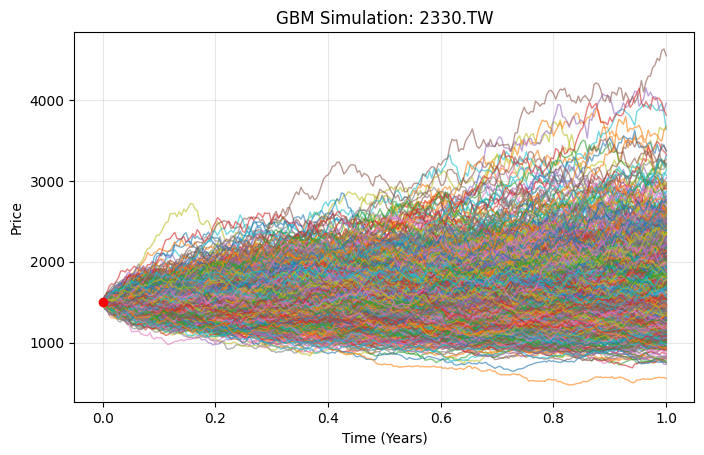

In [46]:
# 1. 實例化
sim = GBMSimulator(ticker='2330.TW', start_date='2000-01-01', end_date='2025-10-31')

# 2. 下載資料並計算參數
sim.fit_data()

# T:模擬幾年, r:無風險利率，也可以不填，有預設, n_days:每年日數, n_paths:模擬路徑數, measure:P測度用mu、Q測度用r
paths = sim.simulate(T_years=1, r=0.02, n_days=250, n_paths=1000, measure="P", seed=10)

# 3. 查詢第 250 天的平均價格(改參數可以查詢範圍內任意期數)
price = sim.get_expectation_price(250)

# 4. 畫圖
sim.plot()